In [1]:
# Copyright (C) 2024 Richard Stiskalek
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
import scienceplots
from warnings import warn
from astropy.cosmology import FlatLambdaCDM
from mpl_toolkits.axes_grid1 import make_axes_locatable

import csiborgtools

from reconstruction_comparison import simname_to_pretty

%load_ext autoreload
%autoreload 2
%matplotlib inline

paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)
fdir = "/mnt/extraspace/rstiskalek/csiborg_postprocessing/peculiar_velocity"

CLUSTERS = {
    "Shapley": (-116.37827331, 69.68752732, -14.90318191),
    "Virgo": (-3.48, 14.86, -2.21),
    "Norma": (-50.26, -7.06, 6.44),
    "Coma": (0.48, 72.79, 10.59),
    "Perseus": (49.94, -10.73, -12.98),
    "Centaurus": (-34.25, 14.93, -7.56)
}

In [5]:
# from astropy.coordinates import SkyCoord
# from astropy.coordinates import Supergalactic
# from astropy.units import deg, Mpc
# from astropy.cosmology import FlatLambdaCDM

# SPEED_OF_LIGHT = 299_792.458 


# cosmo = FlatLambdaCDM(H0=100, Om0=0.3)

# RA = 196.490821
# dec = -33.067461
# dist = cosmo.comoving_distance(0.048)

# c = SkyCoord(ra= RA * deg, dec= dec * deg, distance=dist)
# c = c.transform_to(Supergalactic)
# c.cartesian

In [2]:
def get_field(simname, nsim, kind, MAS, grid):
    # Open the field reader.
    if simname == "csiborg1":
        field_reader = csiborgtools.read.CSiBORG1Field(nsim)
    elif "csiborg2_" in simname:
        simkind = simname.split("_")[-1]
        field_reader = csiborgtools.read.CSiBORG2Field(nsim, simkind)
    elif simname == "csiborg2X":
        field_reader = csiborgtools.read.CSiBORG2XField(nsim)
    elif simname == "Carrick2015":
        folder = "/mnt/extraspace/rstiskalek/catalogs"
        warn(f"Using local paths from `{folder}`.", RuntimeWarning)
        if kind == "density":
            fpath = join(folder, "twompp_density_carrick2015.npy")
            return np.load(fpath).astype(np.float32)
        elif kind == "velocity":
            fpath = join(folder, "twompp_velocity_carrick2015.npy")
            field = np.load(fpath).astype(np.float32)

            # Because the Carrick+2015 data is in the following form:
            # "The velocities are predicted peculiar velocities in the CMB
            # frame in Galactic Cartesian coordinates, generated from the
            # \(\delta_g^*\) field with \(\beta^* = 0.43\) and an external
            # dipole \(V_\mathrm{ext} = [89,-131,17]\) (Carrick et al Table 3)
            # has already been added.""
            field[0] -= 89
            field[1] -= -131
            field[2] -= 17
            field /= 0.43

            return field
        else:
            raise ValueError(f"Unknown field kind: `{kind}`.")
    elif simname == "CLONES":
        field_reader = csiborgtools.read.CLONESField(nsim)
    elif simname == "CF4":
        folder = "/mnt/extraspace/rstiskalek/catalogs/CF4"
        warn(f"Using local paths from `{folder}`.", RuntimeWarning)

        if kind == "density":
            fpath = join(folder, f"CF4_new_128-z008_realization{nsim}_delta.fits")     # noqa
        elif kind == "velocity":
            fpath = join(folder, f"CF4_new_128-z008_realization{nsim}_velocity.fits")  # noqa
        else:
            raise ValueError(f"Unknown field kind: `{kind}`.")

        field = fits.open(fpath)[0].data

        # https://projets.ip2i.in2p3.fr//cosmicflows/ says to multiply by 52
        if kind == "velocity":
            field *= 52

        return field.astype(np.float32)
    elif simname == "Lilow2024":
        folder = "/mnt/extraspace/rstiskalek/catalogs"
        warn(f"Using local paths from `{folder}`.", RuntimeWarning)

        if kind == "density":
            fpath = join(folder, "Lilow2024_density.npy")
            field = np.load(fpath)
        elif kind == "velocity":
            field = []
            for p in ["x", "y", "z"]:
                fpath = join(folder, f"Lilow2024_{p}Velocity.npy")
                field.append(np.load(fpath).astype(np.float32))
            field = np.stack(field)

        return field.astype(np.float32)
    else:
        raise ValueError(f"Unknown simulation name: `{simname}`.")

    # Read in the field.
    if kind == "density":
        field = field_reader.density_field(MAS=MAS, grid=grid)
    elif kind == "velocity":
        field = field_reader.velocity_field(MAS=MAS, grid=grid)
    else:
        raise ValueError(f"Unknown field kind: `{kind}`.")
    
    # NOTE added here 
    if kind == "density" and ("csiborg" in simname or simname == "CLONES"):
        Om0 = csiborgtools.simname2Omega_m(simname)
        cosmo = FlatLambdaCDM(H0=100, Om0=Om0)
        mean_rho_matter = cosmo.critical_density0.to("Msun/kpc^3").value
        mean_rho_matter *= Om0
        field /= mean_rho_matter

    return field

In [3]:
def make_slice(simname, xmin, xmax, ngrid):
    boxsize = csiborgtools.simname2boxsize(simname)

    paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)
    nsims = paths.get_ics(simname)

    if simname in ["Carrick2015", "Lilow2024"]:
        frame = "galactic"
    elif simname in ["CF4", "CLONES"]:
        frame = "supergalactic"
    elif "csiborg" in simname:
        frame = "icrs"
    else:
        raise ValueError(f"Unknown frame for simulation: `{simname}`.")

    out = np.full((len(nsims), ngrid, ngrid), np.nan)

    
    for i, k in enumerate(tqdm(nsims, desc=simname)):
        field = get_field(simname, k, "density", "SPH", 1024)
        slice_values = csiborgtools.field.xy_supergalactic_slice(
            field, boxsize, xmin, xmax, ngrid, frame)

        if simname == "Lilow2024":
            slice_values[np.isnan(slice_values)] = 1

        out[i] = slice_values

    return out


In [4]:
load_from_disk = True
fname = "/mnt/extraspace/rstiskalek/dump/XY_slices.npz"

xmin = -155
xmax = 155
ngrid = 1000

if not load_from_disk:
    xy_carrick = make_slice("Carrick2015", xmin, xmax, ngrid) + 1
    xy_lilow = make_slice("Lilow2024", xmin, xmax, ngrid)
    xy_CF4 = make_slice("CF4", xmin, xmax, ngrid)
    xy_CB2 = make_slice("csiborg2_main", xmin, xmax, ngrid)
    xy_CB2X = make_slice("csiborg2X", xmin, xmax, ngrid)
    xy_CLONES = make_slice("CLONES", xmin, xmax, ngrid)

    np.savez(fname, carrick=xy_carrick, lilow=xy_lilow,
             CF4=xy_CF4, CB2=xy_CB2, CB2X=xy_CB2X, CLONES=xy_CLONES)
else:
    data = np.load(fname)
    xy_carrick = data["carrick"]
    xy_lilow = data["lilow"]
    xy_CF4 = data["CF4"]
    xy_CB2 = data["CB2"]
    xy_CB2X = data["CB2X"]
    xy_CLONES = data["CLONES"]
    data.close()



rsmooth = None
if rsmooth is not None:
    sigma = rsmooth / ((xmax - xmin) / ngrid)
    print(f"Smoothing with sigma={sigma}")

    for field in [xy_carrick, xy_CF4, xy_CB2, xy_CB2X]:
        for i in range(len(field)):
            field[i] = gaussian_filter(field[i], sigma=sigma)


### Individual plots

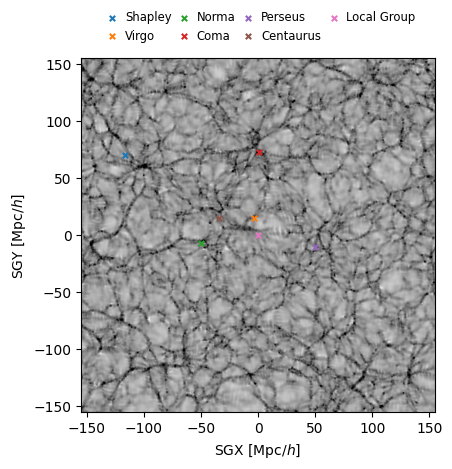

In [5]:
plt.figure()

img = np.mean(xy_CLONES, axis=0)
img = np.clip(img, None, np.percentile(img.ravel(), 99.75))
img = np.log10(img)

plt.imshow(img, origin="lower", cmap="gray_r", extent=[xmin, xmax, xmin, xmax])

kwargs = {"marker": "x", "s": 15}
for name, coords in CLUSTERS.items():
    plt.scatter(*coords[:2], label=name, **kwargs)

plt.scatter(0, 0, label="Local Group", **kwargs)

plt.xlabel(r"$\mathrm{SGX} ~ [\mathrm{Mpc} / h]$")
plt.ylabel(r"$\mathrm{SGY} ~ [\mathrm{Mpc} / h]$")

plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.025),
           ncol=4, fontsize="small", frameon=False,
           handletextpad=0.1,  # Reduce space between marker and text
           borderpad=0.1,      # Reduce padding between legend and border
           columnspacing=0.1)  # Reduce space between columns

plt.tight_layout()
plt.savefig("../../plots/slice_test.png", dpi=450, bbox_inches="tight")
plt.show()

### CF4 data check

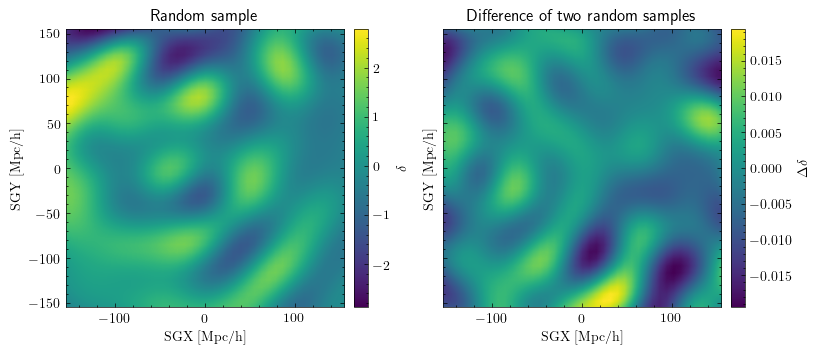

In [6]:
with plt.style.context("science"):
    fig, axs = plt.subplots(1, 2, figsize=(8.3, 8.3 * 0.75), sharex=True, sharey=True)

    kwargs = {
        "origin": "lower", "cmap": "viridis", "extent": [xmin, xmax, xmin, xmax]}
    im0 = axs[0].imshow(xy_CF4[0], **kwargs)
    im1 = axs[1].imshow(xy_CF4[0] - xy_CF4[15], **kwargs)

    axs[0].set_title("Random sample")
    axs[1].set_title("Difference of two random samples")

    # Adjust colorbars to be the same height as the plots using make_axes_locatable
    labels = [r"$\delta$", r"$\Delta \delta$"]
    for i, im in enumerate([im0, im1]):
        divider = make_axes_locatable(axs[i])
        cax = divider.append_axes("right", size="5%", pad=0.1)  # Create colorbar axis
        fig.colorbar(im, label=labels[i], cax=cax, orientation="vertical")

    for i in range(2):
        axs[i].set_ylabel(r"$\mathrm{SGY} ~ [\mathrm{Mpc / h}]$")
        axs[i].set_xlabel(r"$\mathrm{SGX} ~ [\mathrm{Mpc / h}]$")

    fig.tight_layout()
    fig.savefig("../../plots/CF4_test.png", dpi=450)
    fig.show()

## Paper plots

### 1. Comparison of fields

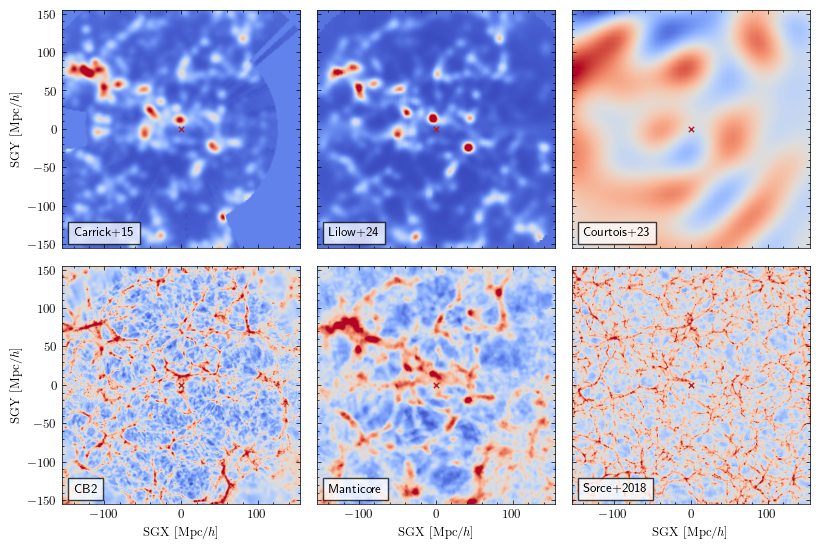

In [8]:
with plt.style.context("science"):
    plt.rcParams.update({'font.size': 9})

    imshow_kwargs = {"origin": "lower", "cmap": "coolwarm",
                     "extent": [xmin, xmax, xmin, xmax]}

    figwidth = 8.3
    fig, axs = plt.subplots(2, 3, figsize=(figwidth, 0.67 * figwidth),
                            sharex="col", sharey=True)
    fig.subplots_adjust(wspace=0, hspace=0)

    # Carrick 2015
    img = np.mean(xy_carrick, axis=0)
    img = np.clip(img, None, np.percentile(img.ravel(), 99.75))
    axs[0, 0].imshow(img, **imshow_kwargs)
    axs[0, 0].text(
        0.05, 0.05, simname_to_pretty("Carrick2015"), transform=axs[0, 0].transAxes,
        bbox=dict(facecolor='white', alpha=0.75))

    # Lilow 2024
    img = np.mean(xy_lilow, axis=0)
    img = np.clip(img, None, np.percentile(img.ravel(), 99.75))
    axs[0, 1].imshow(img, **imshow_kwargs)
    axs[0, 1].text(
        0.05, 0.05, simname_to_pretty("Lilow2024"), transform=axs[0, 1].transAxes,
        bbox=dict(facecolor='white', alpha=0.75))

    # CF4
    img = np.mean(xy_CF4, axis=0)
    img = np.clip(img, None, np.percentile(img.ravel(), 99.9))
    axs[0, 2].imshow(img, **imshow_kwargs)
    axs[0, 2].text(
        0.05, 0.05, simname_to_pretty("CF4"), transform=axs[0, 2].transAxes,
        bbox=dict(facecolor='white', alpha=0.75))

    # csiborg2_main 
    img = np.mean(xy_CB2, axis=0)
    img = np.clip(img, None, np.percentile(img.ravel(), 99))
    img = np.log10(img)
    axs[1, 0].imshow(img, **imshow_kwargs)
    axs[1, 0].text(
        0.05, 0.05, simname_to_pretty("csiborg2_main"), transform=axs[1, 0].transAxes,
        bbox=dict(facecolor='white', alpha=0.75))

    # Manticore
    img = np.mean(xy_CB2X, axis=0)
    img = np.clip(img, None, np.percentile(img.ravel(), 99))
    img = np.log10(img)
    axs[1, 1].imshow(img, **imshow_kwargs)
    axs[1, 1].text(
        0.05, 0.05, simname_to_pretty("csiborg2X"), transform=axs[1, 1].transAxes,
        bbox=dict(facecolor='white', alpha=0.75))

    # Jenny's field
    img = np.mean(xy_CLONES, axis=0)
    img = np.clip(img, None, np.percentile(img.ravel(), 99.))
    img = np.log10(img)
    axs[1, 2].imshow(img, **imshow_kwargs)
    axs[1, 2].text(
        0.05, 0.05, simname_to_pretty("CLONES"), transform=axs[1, 2].transAxes,
        bbox=dict(facecolor='white', alpha=0.75))

    for i in range(2):
        axs[i, 0].set_ylabel(r"$\mathrm{SGY} ~ [\mathrm{Mpc} / h]$")

    for i in range(3):
        axs[-1, i].set_xlabel(r"$\mathrm{SGX} ~ [\mathrm{Mpc} / h]$")

    for i in range(2):
        for j in range(3):
            axs[i, j].scatter(0, 0, marker="x", s=15, color="firebrick")

    fig.tight_layout()
    fig.savefig("../../plots/XY_slices.pdf", dpi=450)
    fig.show()